# Correctionlib tutorial

The purpose of this library is to provide a well-structured JSON data format for a
wide variety of ad-hoc correction factors encountered in a typical HEP analysis and
a companion evaluation tool suitable for use in C++ and python programs.
Here we restrict our definition of correction factors to a class of functions with
scalar inputs that produce a scalar output.

In python, the function signature is:

```python
def f(*args: int | float | str) -> float: ...
```

In C++, the signature is:
```cpp
double Correction::evaluate(const std::vector<std::variant<int, double, std::string>>& values) const;
```

The supported function classes include:

  * multi-dimensional binned lookups;
  * binned lookups pointing to multi-argument formulas with a restricted
    math function set (`exp`, `sqrt`, etc.);
  * categorical (string or integer enumeration) maps;
  * input transforms (updating one input value in place);
  * pseudorandom number generation; and
  * compositions of the above.



## Basic evaluator usage
We can import a previously defined set of correction objects using the
```python
correctionlib.CorrectionSet.from_file(filename)
```
or from a string with `.from_string("...")`. The `from_file` invocation accepts JSON or gzipped JSON data.
The `CorrectionSet` acts as a dictionary of `Correction` objects.

In [1]:
import correctionlib

ceval = correctionlib.CorrectionSet.from_file("mycorrections.json")
list(ceval.keys())

['gen2_to_gen1', 'phimod', 'ptweight']

Each correction has a name, description, version, and a input and output specification:

In [2]:
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

Correction gen2_to_gen1 has 2 inputs
   Input pt (real): pt
   Input eta (real): eta
Correction phimod has 2 inputs
   Input phi (real): 
   Input q (int): Particle charge
Correction ptweight has 2 inputs
   Input pt (real): Muon transverse momentum
   Input syst (string): Systematic


Most important, each correction has a `.evaluate(...)` method that accepts scalars or numpy arrays:

In [3]:
ceval["phimod"].evaluate(1.2, -1)

1.0278771158865732

Note that the input types are strict (not coerced) to help catch bugs early, e.g.

In [4]:
# will not work
# ceval["phimod"].evaluate(1.2, -1.0)

In [5]:
import numpy as np
ptvals = np.random.exponential(15.0, size=10)

ceval["ptweight"].evaluate(ptvals, "nominal")

array([1.1 , 1.04, 1.08, 1.1 , 1.1 , 1.06, 1.1 , 1.1 , 1.1 , 1.1 ])

Currently, only numpy-compatible awkward arrays are accepted, but a jagged array can be flattened and re-wrapped quite easily:

In [6]:
import awkward as ak

ptjagged = ak.Array([[10.1, 20.2, 30.3], [40.4, 50.5], [60.6]])

ptflat, counts = ak.flatten(ptjagged), ak.num(ptjagged)
weight = ak.unflatten(
    ceval["ptweight"].evaluate(ptflat, "nominal"),
    counts=counts,
)
weight

<Array [[1.1, 1.08, 1.06], [1.04, ...], [1.02]] type='3 * var * float64'>

## Creating new corrections

Alongside the evaluator we just demonstrated, `correctionlib` also contains a complete JSON Schema defining the expected fields and types found in a correction json object. The complete schema (version 2) is defined in the [documentation](https://cms-nanoaod.github.io/correctionlib/schemav2.html). In the package, we use [pydantic](https://pydantic-docs.helpmanual.io/) to help us validate the data and build correction objects in an easier way. The basic object is the `Correction` which, besides some metadata like a name and version, defines upfront the inputs and output. Below we make our first correction, which will always return `1.1` as the output:

In [7]:
import correctionlib.schemav2 as cs

corr = cs.Correction(
    name="ptweight",
    version=1,
    inputs=[
        cs.Variable(name="pt", type="real", description="Muon transverse momentum"),
    ],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=1.1,
)
corr

Correction(name='ptweight', description=None, version=1, inputs=[Variable(name='pt', type='real', description='Muon transverse momentum')], output=Variable(name='weight', type='real', description='Multiplicative event weight'), generic_formulas=None, data=1.1)

The resulting object can be manipulated in-place as needed. Note that this correction object is not an evluator instance as we saw before. We can convert from the schema to an evaluator with the `.to_evaluator()` function:

In [8]:
corr.to_evaluator().evaluate(12.3)

1.1

A nicer printout is also available through `rich`:

In [9]:
import rich

rich.print(corr)

📈 ptweight (v1)
No description
Node counts: 
╭───────── ▶ input ──────────╮
│ pt (real)                  │
│ Muon transverse momentum   │
│ Range: unused, overflow ok │
╰────────────────────────────╯
╭───────── ◀ output ──────────╮
│ weight (real)               │
│ Multiplicative event weight │
╰─────────────────────────────╯

The `data=` field of the correction is the root node of a tree of objects defining how the correction is to be evaluated. In the first example, it simply terminates at this node, returning always the float value `1.1`. We have many possible node types:

- Binning: for 1D binned variable, each bin can be any type;
- MultiBinning: an optimization for nested 1D Binnings, this can lookup n-dimensional binned values;
- Category: for discrete dimensions, either integer or string types;
- Formula: arbitrary formulas in up to four (real or integer-valued) input variables;
- FormulaRef: an optimization for repeated use of the same formula with different coefficients;
- Transform: useful to rewrite an input for all downstream nodes;
- HashPRNG: a deterministic pseudorandom number generator; and
- float: a constant value

Let's create our first binned correction. We'll have to decide how to handle inputs that are out of range with the `flow=` attribute. Try switching `"clamp"` with `"error"` or another content node.

In [10]:
ptweight = cs.Correction(
    name="ptweight",
    version=1,
    inputs=[cs.Variable(name="pt", type="real", description="Muon transverse momentum")],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=cs.Binning(
        nodetype="binning",
        input="pt",
        edges=[10, 20, 30, 40, 50, 80, 120],
        content=[1.1, 1.08, 1.06, 1.04, 1.02, 1.0],
        flow="clamp",
    ),
)

rich.print(ptweight)

📈 ptweight (v1)
No description
Node counts: Binning: 1
╭───────────── ▶ input ─────────────╮
│ pt (real)                         │
│ Muon transverse momentum          │
│ Range: [10.0, 120.0), overflow ok │
╰───────────────────────────────────╯
╭───────── ◀ output ──────────╮
│ weight (real)               │
│ Multiplicative event weight │
╰─────────────────────────────╯

In [11]:
ptweight.to_evaluator().evaluate(230.0)

1.0

## Formulas

Formula support currently includes a mostly-complete subset of the ROOT library TFormula class, and is implemented in a threadsafe standalone manner. The parsing grammar is formally defined and parsed through the use of a header-only PEG parser library. This allows for extremely fast parsing of thousands of formulas encountered sometimes in binned formula (spline) correction types. Below we demonstrate a simple formula for a made-up $\phi$-dependent efficiency correction. This also demonstrates nesting a content node inside another for the first time, with the outer Category node defining which formula to use depending on the particle charge

In [12]:
phimod = cs.Correction(
    name="phimod",
    description="Phi-dependent tracking efficiency, or something?",
    version=1,
    inputs=[
        cs.Variable(name="phi", type="real"),
        cs.Variable(name="q", type="int", description="Particle charge"),
    ],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=cs.Category(
        nodetype="category",
        input="q",
        content=[
            cs.CategoryItem(
                key=1,
                value=cs.Formula(
                    nodetype="formula",
                    variables=["phi"],
                    parser="TFormula",
                    expression="(1+0.1*sin(x+0.3))/(1+0.07*sin(x+0.4))",
                ),
            ),
            cs.CategoryItem(
                key=-1,
                value=cs.Formula(
                    nodetype="formula",
                    variables=["phi"],
                    parser="TFormula",
                    expression="(1+0.1*sin(x+0.31))/(1+0.07*sin(x+0.39))",
                ),
            ),
        ]
    ),
)
rich.print(phimod)

📈 phimod (v1)
Phi-dependent tracking efficiency, or something?
Node counts: Category: 1, Formula: 2
╭──────────── ▶ input ────────────╮ ╭──── ▶ input ────╮
│ phi (real)                      │ │ q (int)         │
│ No description                  │ │ Particle charge │
│ Range: [-inf, inf), overflow ok │ │ Values: -1, 1   │
╰─────────────────────────────────╯ ╰─────────────────╯
╭───────── ◀ output ──────────╮
│ weight (real)               │
│ Multiplicative event weight │
╰─────────────────────────────╯

In [13]:
phimod.to_evaluator().evaluate(1.23, 1)

1.0280774577481218

Try evaluating the correction for a neutral particle (`charge=0`) What can we change to the above definition to allow it to return a reasonable value for neutral particles rather than an error?

## Converting from histograms

Often one wants to convert a histogram into a correction object. Here we show how to do that using histgrams made with the [hist](https://hist.readthedocs.io/en/latest/) package, but any histogram that respects the [Unified Histogram Interface Plottable](https://uhi.readthedocs.io/en/latest/plotting.html#plotting) protocol (including, for example, ROOT TH1s) should work as well.

Note: some of the conversion utilities require extra packages installed. The simplest way to ensure you have all dependencies is via the `pip install correctionlib[convert]` extras configuration.

Here we create some mock data for two slightly different pt and eta spectra (say, from two different generators) and derive a correction to reweight one sample to the other.

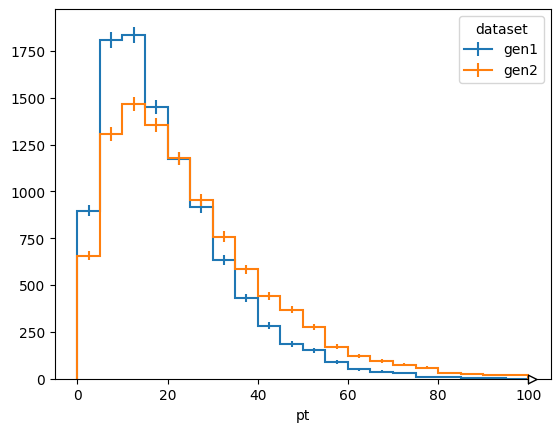

In [14]:
import numpy as np
import hist
import matplotlib.pyplot as plt

dists = (
    hist.Hist.new
    .StrCat(["gen1", "gen2"], name="dataset", growth=True)
    .Reg(20, 0, 100, name="pt")
    .Reg(4, -3, 3, name="eta")
    .Weight()
    .fill(
        dataset="gen1",
        pt=np.random.exponential(scale=10.0, size=10000) + np.random.exponential(scale=10.0, size=10000),
        eta=np.random.normal(scale=1, size=10000)
    )
    .fill(
        dataset="gen2",
        pt=np.random.exponential(scale=10.0, size=10000) + np.random.exponential(scale=15.0, size=10000),
        eta=np.random.normal(scale=1.1, size=10000)
    )
)

fig, ax = plt.subplots()
dists[:, :, sum].plot1d(ax=ax)
ax.legend(title="dataset")

Now we derive a correction as a function of $p_T$ and $\eta$ to `gen2` such that it agrees with `gen1`. We’ll set it to 1 anywhere we run out of statistics for the correction, to avoid divide by zero issues.

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x11bbb0770>, cbar=<matplotlib.colorbar.Colorbar object at 0x11bd10830>, text=[])

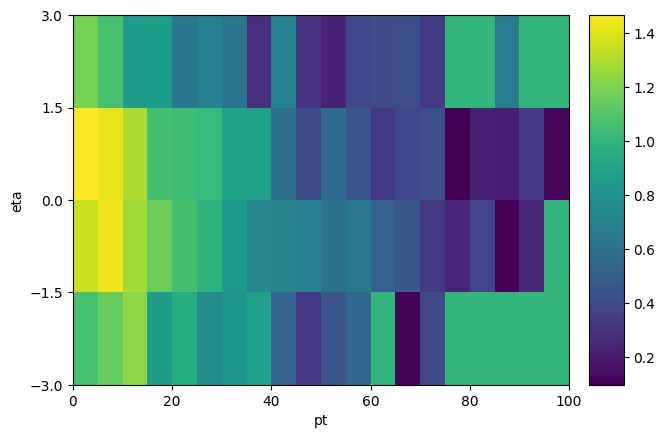

In [15]:
num = dists["gen1", :, :].values()
den = dists["gen2", :, :].values()
sf = np.where(
    (num > 0) & (den > 0),
    num / np.maximum(den, 1) * den.sum() / num.sum(),
    1.0,
)

# a quick way to plot the scale factor is to steal the axis definitions from the input histograms:
sfhist = hist.Hist(*dists.axes[1:], data=sf)
sfhist.plot2d()

Now we use `correctionlib.convert.from_histogram(...)` to convert the scale factor into a correction object

In [16]:
import correctionlib.convert

# without a name, the resulting object will fail validation
sfhist.name = "gen2_to_gen1"
sfhist.label = "out"
gen2_to_gen1 = correctionlib.convert.from_histogram(sfhist)
gen2_to_gen1.description = "Reweights gen2 to agree with gen1"
# set overflow bins behavior (default is to raise an error when out of bounds)
gen2_to_gen1.data.flow = "clamp"
rich.print(gen2_to_gen1)

📈 gen2_to_gen1 (v0)
Reweights gen2 to agree with gen1
Node counts: MultiBinning: 1
╭──────────── ▶ input ─────────────╮ ╭──────────── ▶ input ────────────╮
│ pt (real)                        │ │ eta (real)                      │
│ pt                               │ │ eta                             │
│ Range: [0.0, 100.0), overflow ok │ │ Range: [-3.0, 3.0), overflow ok │
╰──────────────────────────────────╯ ╰─────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

Now we generate some new mock data as if it was drawn from `gen2` and reweight it with our correction. Let's see if our correction closes:

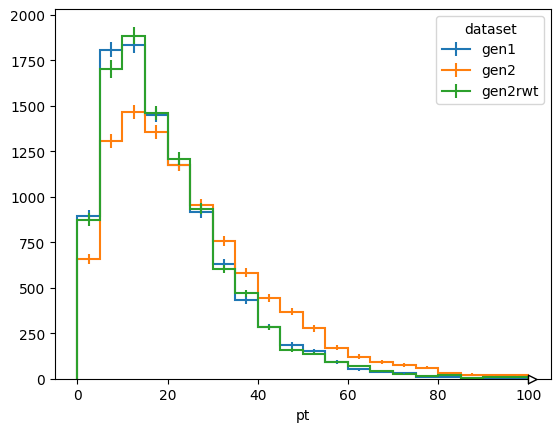

In [17]:
ptvals = np.random.exponential(scale=10.0, size=10000) + np.random.exponential(scale=15.0, size=10000)
etavals = np.random.normal(scale=1.1, size=10000)

dists.fill(
    dataset="gen2rwt",
    pt=ptvals,
    eta=etavals,
    weight=gen2_to_gen1.to_evaluator().evaluate(ptvals, etavals)
)

fig, ax = plt.subplots()
dists[:, :, sum].plot1d(ax=ax)
ax.legend(title="dataset")

## Polynomial fits

It is apparent from the plot of the 2D correction factor that we do not have sufficient sample statistics to derive a smooth correction. One approach to improve the quality is to fit it to a polynomial. A utility method, `correctionlib.convert.ndpolyfit` allows to fit an arbitrary-dimensional polynomial to a set of data points and return a correction object representing the result.

In [18]:
centers = np.meshgrid(*[ax.centers for ax in sfhist.axes], indexing="ij")

gen2_to_gen1_poly, fit = correctionlib.convert.ndpolyfit(
    points=[c.flatten() for c in centers],
    values=sfhist.values().flatten(),
    weights=1/sfhist.variances().flatten(),
    varnames=[ax.name for ax in sfhist.axes],
    degree=(2, 2),
)
gen2_to_gen1_poly.name = "gen2_to_gen1_poly"
rich.print(gen2_to_gen1_poly)

📈 gen2_to_gen1_poly (v1)
Fit to polynomial of order 2,2
Fit status: The unconstrained solution is optimal.
chi2 = 5.306256132294569, P(dof=71) = 1.000
Node counts: Formula: 1
╭──────────── ▶ input ────────────╮ ╭──────────── ▶ input ────────────╮
│ pt (real)                       │ │ eta (real)                      │
│ No description                  │ │ No description                  │
│ Range: [-inf, inf), overflow ok │ │ Range: [-inf, inf), overflow ok │
╰─────────────────────────────────╯ ╰─────────────────────────────────╯
╭─── ◀ output ───╮
│ output (real)  │
│ No description │
╰────────────────╯

Let's check the closure of this method to the previous one:

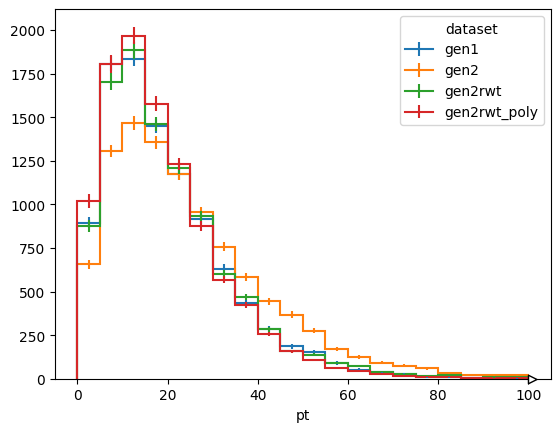

In [19]:
dists.fill(
    dataset="gen2rwt_poly",
    pt=ptvals,
    eta=etavals,
    weight=gen2_to_gen1_poly.to_evaluator().evaluate(ptvals, etavals)
)


fig, ax = plt.subplots()
dists[:, :, sum].plot1d(ax=ax)
ax.legend(title="dataset")

Another important consideration is that evaluating a polynomial in Horner form is $O(k)$ where $k$ is the order of the polynomial, while looking up a value in a non-uniform binning is $O(log(n))$ in $n$ bins. Depending on the situation, an acceptable $k$ may be lower than $log(n)$. In our case, the $(2,2)$ polynomial we derived evaluates slower than the binning, partially because it is not evaluated in Horner form:

In [20]:
corr_bin = gen2_to_gen1.to_evaluator()
corr_pol = gen2_to_gen1_poly.to_evaluator()

%timeit corr_bin.evaluate(ptvals, etavals)
%timeit corr_pol.evaluate(ptvals, etavals)

1.06 ms ± 26.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.65 ms ± 45.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


However, in an alternative situation, the same may not hold:

In [21]:
%timeit np.searchsorted([0.,  5., 10., 15., 20., 25., 30., 35.], ptvals)
%timeit np.polyval([0.01, 0.1, 1.0], ptvals)

39.4 μs ± 150 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
14.9 μs ± 63.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Resolution models

In some instances, one might want to smear the value of a variable, e.g. jet energy, to simulate a degradation of resolution with respect to what was expected from simulation. If we can deterministically generate pseudorandom numbers, we can then use them after suitable scaling to correct the jet momentum. To do so in correctionlib, we gather entropy sources such as the kinematics of the jet and event-level quantities, hash them together using the extremely fast [xxhash](https://cyan4973.github.io/xxHash/) algorithm to generate an integer seed, and use that to initialize a [PCG64](https://www.pcg-random.org/) random number generator, which can then be drawn from to build a normal-distributed (or otherwise) value. See [issue #130](https://github.com/cms-nanoAOD/correctionlib/issues/130) for further details.

In [22]:
resrng = cs.Correction(
    name="resrng",
    description="Deterministic smearing value generator",
    version=1,
    inputs=[
        cs.Variable(name="pt", type="real", description="Unsmeared jet pt"),
        cs.Variable(name="eta", type="real", description="Jet pseudorapdity"),
        cs.Variable(name="phi", type="real", description="Jet phi (entropy source)"),
        cs.Variable(name="evt", type="int", description="Event number (entropy source)"),
    ],
    output=cs.Variable(name="rng", type="real"),
    data=cs.HashPRNG(
        nodetype="hashprng",
        inputs=["pt", "eta", "phi", "evt"],
        distribution="stdnormal",
    )
)

resmodel = cs.Correction(
    name="resmodel",
    description="A jet energy resolution smearing model",
    version=1,
    inputs=[
        cs.Variable(name="pt", type="real", description="Unsmeared jet pt"),
    ],
    output=cs.Variable(name="scale", type="real"),
    data=cs.Binning(
        nodetype="binning",
        input="pt",
        edges=[10, 20, 30, 40, 50, 80, 120],
        content=[0.3, 0.25, 0.20, 0.14, 0.06, 0.02],
        flow="clamp",
    )
)

Text(0.5, 0, 'Smeared $p_T$ - Unsmeared $p_T$')

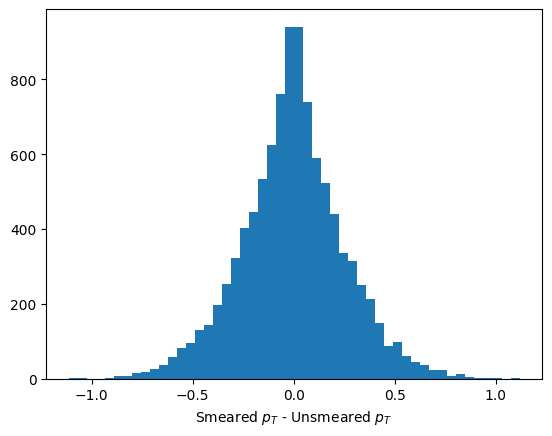

In [23]:
# dummy distributions
phivals = np.random.uniform(-np.pi, np.pi, size=10000)
eventnumber = np.random.randint(123456, 123567, size=10000)

# apply a pT-dependent smearing by scaling the standard normal draw
smear_val = (
    resrng.to_evaluator().evaluate(ptvals, etavals, phivals, eventnumber)
    * resmodel.to_evaluator().evaluate(ptvals)
)
pt_smeared = np.maximum(ptvals + smear_val, 0.0)


fig, ax = plt.subplots()
ax.hist(pt_smeared - ptvals, bins=50)
ax.set_xlabel("Smeared $p_T$ - Unsmeared $p_T$")

## Chaining with CompoundCorrection

A CompoundCorrection allows to apply a sequence of corrections in order, refering to other corrections in the same CorrectionSet object. For example, we can merge the smearing and RNG into one:

In [24]:
cset = cs.CorrectionSet(
    schema_version=2,
    corrections=[
        resmodel,
        resrng,
    ],
    compound_corrections=[
        cs.CompoundCorrection(
            name="resolution_model",
            inputs=[
                cs.Variable(name="pt", type="real", description="Unsmeared jet pt"),
                cs.Variable(name="eta", type="real", description="Jet pseudorapdity"),
                cs.Variable(name="phi", type="real", description="Jet phi (entropy source)"),
                cs.Variable(name="evt", type="int", description="Event number (entropy source)"),
            ],
            output=cs.Variable(name="shift", type="real", description="Additive shift to jet pT"),
            inputs_update=[],
            input_op="*",
            output_op="*",
            stack=["resmodel", "resrng"],
        )
    ]
)

oneshot = cset.to_evaluator().compound["resolution_model"]

print("One-shot smearing is equivalent to two-step procedure?")
print(np.allclose(
    oneshot.evaluate(ptvals, etavals, phivals, eventnumber),
    smear_val,
))

One-shot smearing is equivalent to two-step procedure?
True


Note the `inputs_update` and `input_op` fields can be used to update inputs as they go through the stack, which is useful for chained corrections such as jet energy corrections.

## Systematics

There are many ways to encode systematic uncertainties within correctionlib, although no nodes are dedicated to the task. See [issue #4](https://github.com/cms-nanoAOD/correctionlib/issues/4) to discuss further the idea of having a dedicated systematic node. The most straightforward option is to use a Category node with string lookup to switch the behavior depending on the active systematic. Below we modify our `ptweight` from before to produce a systematically larger event weight when the `MuonEffUp` systematic is specified, while producing the nominal event weight for any other string key, by taking advantage of the `default=` keywoard in the Category node. We also use the `flow=` keyword in the shifted binning to increase the systematic uncertainty for data with muon $p_T$ larger than 120.

In [25]:
ptweight = cs.Correction(
    name="ptweight",
    version=1,
    inputs=[
        cs.Variable(name="pt", type="real", description="Muon transverse momentum"),
        cs.Variable(name="syst", type="string", description="Systematic")
    ],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=cs.Category(
        nodetype="category",
        input="syst",
        content=[
            cs.CategoryItem(
                key="MuonEffUp",
                value=cs.Binning(
                    nodetype="binning",
                    input="pt",
                    edges=[0, 10, 20, 30, 40, 50, 80, 120],
                    content=[1.14, 1.14, 1.09, 1.07, 1.05, 1.03, 1.01],
                    flow=1.03,
                ),
            ),
        ],
        default=cs.Binning(
            nodetype="binning",
            input="pt",
            edges=[10, 20, 30, 40, 50, 80, 120],
            content=[1.1, 1.08, 1.06, 1.04, 1.02, 1.0],
            flow="clamp",
        ),
    ),
)

rich.print(ptweight)

📈 ptweight (v1)
No description
Node counts: Category: 1, Binning: 2
╭──────────── ▶ input ─────────────╮ ╭───── ▶ input ─────╮
│ pt (real)                        │ │ syst (string)     │
│ Muon transverse momentum         │ │ Systematic        │
│ Range: [0.0, 120.0), overflow ok │ │ Values: MuonEffUp │
╰──────────────────────────────────╯ │ has default       │
                                     ╰───────────────────╯
╭───────── ◀ output ──────────╮
│ weight (real)               │
│ Multiplicative event weight │
╰─────────────────────────────╯

In [26]:
ptweight.to_evaluator().evaluate(135., "nominal")

1.0

## Writing it all out

In [27]:
cset = cs.CorrectionSet(
    schema_version=2,
    description="my custom corrections",
    corrections=[
        gen2_to_gen1,
        ptweight,
        phimod,
    ],
)

with open("mycorrections.json", "w") as fout:
    fout.write(cset.model_dump_json(exclude_unset=True))
    
import gzip

with gzip.open("mycorrections.json.gz", "wt") as fout:
    fout.write(cset.model_dump_json(exclude_unset=True))

## Command-line utility

The `correction` utility, bundled with the library, provides useful tools for viewing, combining, and validating correction json sets. It also can provide the necessary compile flags for C++ programs to use correctionlib:

In [28]:
!correction --help

usage: correction [-h] [--width WIDTH] [--html HTML]
                  {validate,summary,merge,config} ...

Command-line interface to correctionlib.

positional arguments:
  {validate,summary,merge,config}
    validate            Check if all files are valid
    summary             Print a summmary of the corrections
    merge               Merge one or more correction files and print to stdout
    config              Configuration and linking information

options:
  -h, --help            show this help message and exit
  --width WIDTH         Rich output width
  --html HTML           Save terminal output to an HTML file


In [29]:
!correction config -h

usage: correction config [-h] [-v] [--incdir] [--cflags] [--libdir]
                         [--ldflags] [--rpath] [--cmake]

options:
  -h, --help     show this help message and exit
  -v, --version  Return correctionlib current version
  --incdir
  --cflags
  --libdir
  --ldflags
  --rpath        Include library path hint in linker
  --cmake        CMake dependency flags


In [30]:
%%file main.cc
#include <iostream>
#include "correction.h"

int main() {
    auto cset = correction::CorrectionSet::from_file("mycorrections.json.gz");
    
    double val = cset->at("ptweight")->evaluate({15.0, "nominal"});
    std::cout << val << std::endl;
    return 0;
}

Overwriting main.cc


In [31]:
!g++ main.cc -o main $(correction config --cflags --ldflags --rpath)

On some platforms, if you see errors such as
```
main.cc:(.text+0x17d): undefined reference to `correction::CorrectionSet::from_file(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&)'
```
in the above compilation, you may need to add `-D_GLIBCXX_USE_CXX11_ABI=0` to the arguments.

In [32]:
!./main

1.1
